In [1]:
!pip install sentence-transformers scikit-learn matplotlib seaborn pandas numpy scipy -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded!")

Libraries loaded!


In [3]:
from google.colab import files
print("upload frontier_v3_raw_responses_*.csv file：")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"\nfinish: {filename}")

upload frontier_v3_raw_responses_*.csv file：


Saving frontier_v3_raw_responses_20260128_042834.csv to frontier_v3_raw_responses_20260128_042834.csv

finish: frontier_v3_raw_responses_20260128_042834.csv


In [4]:
# ============================================
# 加载数据
# ============================================

df = pd.read_csv(filename)
print(f"Loaded {len(df)} responses")
print(f"\nModels: {df['model'].unique()}")
print(f"Languages: {df['language'].unique()}")
print(f"Prompts: {df['prompt_id'].unique()}")

df.head()

Loaded 44 responses

Models: ['GPT-5.1' 'DeepSeek-V3.2']
Languages: ['Chinese' 'English']
Prompts: ['A1' 'A2' 'A3' 'B1' 'B2' 'B3' 'C1' 'C2' 'D1' 'D2' 'D3']


,prompt_id,category,model,model_origin,model_tier,language,prompt,response,timestamp
0,A1,A,GPT-5.1,US,frontier,Chinese,傣族是什么？,傣族，简单说，是中国和东南亚地区一个以稻作文明和佛教文化著称的民族/民族共同体。\n\n重点...,2026-01-28T03:18:41.820028
1,A1,A,GPT-5.1,US,frontier,English,What are the Dai people?,The Dai are an ethnic group of Tai-speaking pe...,2026-01-28T03:18:50.807192
2,A1,A,DeepSeek-V3.2,China,frontier,Chinese,傣族是什么？,傣族是中国的一个少数民族，主要分布在云南省的西双版纳傣族自治州、德宏傣族景颇族自治州、临沧市...,2026-01-28T03:18:58.781777
3,A1,A,DeepSeek-V3.2,China,frontier,English,What are the Dai people?,The Dai people are one of the ethnic minority ...,2026-01-28T03:19:09.444001
4,A2,A,GPT-5.1,US,frontier,Chinese,傣语和泰语是什么关系？,简单说：傣语和泰语是“同一家族的近亲”，但不是同一种语言，更不能简单当成“方言关系”。\n\...,2026-01-28T03:19:39.803907


In [5]:

# Model-Language group
df['group'] = df['model'] + '-' + df['language'].apply(lambda x: 'EN' if x == 'English' else 'ZH')

# Prompt category
category_map = {
    'A': 'Factual',
    'B': 'Cultural',
    'C': 'Identity',
    'D': 'Narrative'
}
df['category_name'] = df['category'].map(category_map)

print("Groups created:")
print(df['group'].value_counts())

Groups created:
group
GPT-5.1-ZH          11
GPT-5.1-EN          11
DeepSeek-V3.2-ZH    11
DeepSeek-V3.2-EN    11
Name: count, dtype: int64


In [6]:
print("Loading multilingual embedding model...")
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print(f"✅ Model loaded: paraphrase-multilingual-MiniLM-L12-v2")
print(f"   Embedding dimension: 384")

Loading multilingual embedding model...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Model loaded: paraphrase-multilingual-MiniLM-L12-v2
   Embedding dimension: 384


In [7]:
# ============================================
# generate Embeddings
# ============================================

print("Encoding responses...")
embeddings = model.encode(df['response'].tolist(), show_progress_bar=True)

print(f"\n✅ Encoded {len(embeddings)} responses")
print(f"   Shape: {embeddings.shape}")

Encoding responses...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


✅ Encoded 44 responses
   Shape: (44, 384)


Running t-SNE...


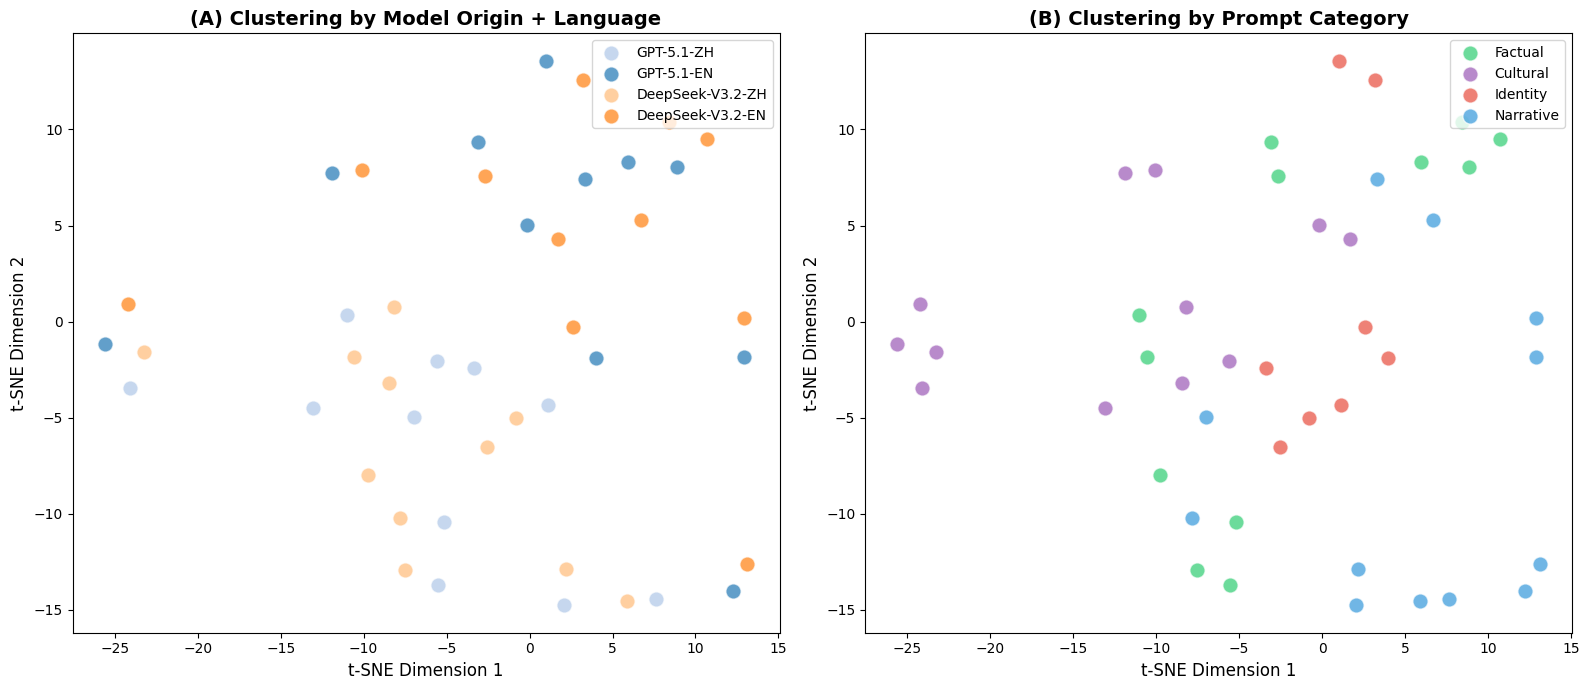


✅ Saved: frontier_figure1_tsne_clusters.png


In [8]:
# ============================================
# FIGURE 1: t-SNE Clustering by Model + Language
# ============================================

print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(10, len(df)-1))
coords = tsne.fit_transform(embeddings)

df['tsne_x'] = coords[:, 0]
df['tsne_y'] = coords[:, 1]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Color scheme for Frontier models
colors = {
    'GPT-5.1-EN': '#1f77b4',      # Blue
    'GPT-5.1-ZH': '#aec7e8',      # Light Blue
    'DeepSeek-V3.2-EN': '#ff7f0e', # Orange
    'DeepSeek-V3.2-ZH': '#ffbb78'  # Light Orange
}

# Left: By Model + Language
for group in df['group'].unique():
    mask = df['group'] == group
    ax1.scatter(df.loc[mask, 'tsne_x'], df.loc[mask, 'tsne_y'],
                label=group, c=colors.get(group, 'gray'), s=120, alpha=0.7, edgecolors='white')

ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax1.set_title('(A) Clustering by Model Origin + Language', fontweight='bold', fontsize=14)
ax1.legend(loc='upper right')

# Right: By Prompt Category
cat_colors = {'Factual': '#2ecc71', 'Cultural': '#9b59b6', 'Identity': '#e74c3c', 'Narrative': '#3498db'}
for cat in df['category_name'].unique():
    mask = df['category_name'] == cat
    ax2.scatter(df.loc[mask, 'tsne_x'], df.loc[mask, 'tsne_y'],
                label=cat, c=cat_colors.get(cat, 'gray'), s=120, alpha=0.7, edgecolors='white')

ax2.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax2.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax2.set_title('(B) Clustering by Prompt Category', fontweight='bold', fontsize=14)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('frontier_figure1_tsne_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: frontier_figure1_tsne_clusters.png")

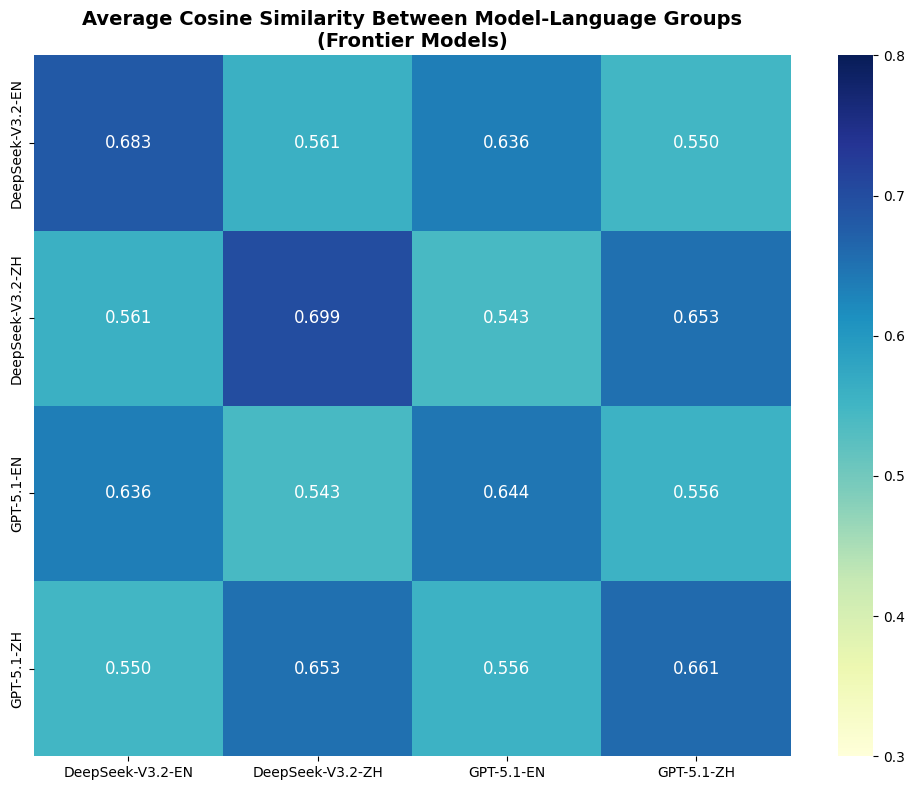


✅ Saved: frontier_figure2_similarity_heatmap.png


In [9]:
# ============================================
# FIGURE 2: Similarity Heatmap
# ============================================

groups = sorted(df['group'].unique())
n_groups = len(groups)

# Calculate group-level similarity matrix
sim_matrix = np.zeros((n_groups, n_groups))

for i, g1 in enumerate(groups):
    for j, g2 in enumerate(groups):
        mask1 = df['group'] == g1
        mask2 = df['group'] == g2

        emb1 = embeddings[mask1]
        emb2 = embeddings[mask2]

        sim = cosine_similarity(emb1, emb2).mean()
        sim_matrix[i, j] = sim

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, xticklabels=groups, yticklabels=groups,
            annot=True, fmt='.3f', cmap='YlGnBu', vmin=0.3, vmax=0.8,
            annot_kws={'size': 12})
plt.title('Average Cosine Similarity Between Model-Language Groups\n(Frontier Models)',
          fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('frontier_figure2_similarity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: frontier_figure2_similarity_heatmap.png")

In [10]:
# ============================================
# KEY METRICS: Language vs Model Origin Effect
# ============================================

print("\n" + "=" * 60)
print("KEY FINDING: Language vs Model Origin Effect")
print("=" * 60)

# Calculate pairwise similarities
same_lang_diff_model = []  # EN-EN or ZH-ZH across models
same_model_diff_lang = []  # Same model, EN vs ZH

for i, g1 in enumerate(groups):
    for j, g2 in enumerate(groups):
        if i < j:  # Avoid duplicates
            # Parse group names
            m1, l1 = g1.rsplit('-', 1)
            m2, l2 = g2.rsplit('-', 1)

            if l1 == l2 and m1 != m2:  # Same language, different model
                same_lang_diff_model.append(sim_matrix[i, j])
            elif m1 == m2 and l1 != l2:  # Same model, different language
                same_model_diff_lang.append(sim_matrix[i, j])

avg_same_lang = np.mean(same_lang_diff_model)
avg_same_model = np.mean(same_model_diff_lang)

print(f"\n📊 Similarity Analysis:")
print(f"   Same language, different model: {avg_same_lang:.3f}")
print(f"   Same model, different language: {avg_same_model:.3f}")
print(f"   Difference: {avg_same_lang - avg_same_model:.3f}")

if avg_same_lang > avg_same_model:
    print(f"\n   ✅ LANGUAGE DOMINATES over model origin")
    print(f"      (Consistent with v2.1 finding)")
else:
    print(f"\n   ⚠️ MODEL ORIGIN dominates over language")
    print(f"      (Different from v2.1 - interesting!)")


KEY FINDING: Language vs Model Origin Effect

📊 Similarity Analysis:
   Same language, different model: 0.644
   Same model, different language: 0.559
   Difference: 0.086

   ✅ LANGUAGE DOMINATES over model origin
      (Consistent with v2.1 finding)


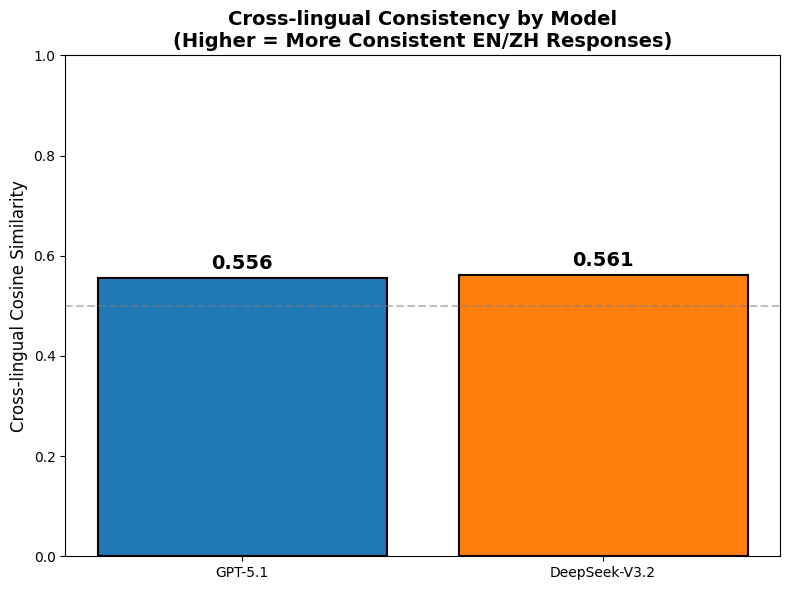


✅ Saved: frontier_figure3_cross_lingual.png

📊 Cross-lingual consistency:
   GPT-5.1: 0.556
   DeepSeek-V3.2: 0.561


In [11]:
# ============================================
# FIGURE 3: Language Gap Comparison
# ============================================

# Cross-lingual consistency per model
models = ['GPT-5.1', 'DeepSeek-V3.2']
cross_lingual_sim = {}

for m in models:
    en_mask = df['group'] == f'{m}-EN'
    zh_mask = df['group'] == f'{m}-ZH'

    if en_mask.sum() > 0 and zh_mask.sum() > 0:
        sim = cosine_similarity(embeddings[en_mask], embeddings[zh_mask]).mean()
        cross_lingual_sim[m] = sim

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

model_colors = {'GPT-5.1': '#1f77b4', 'DeepSeek-V3.2': '#ff7f0e'}
bars = ax.bar(cross_lingual_sim.keys(), cross_lingual_sim.values(),
              color=[model_colors[m] for m in cross_lingual_sim.keys()],
              edgecolor='black', linewidth=1.5)

# Add value labels
for bar, val in zip(bars, cross_lingual_sim.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Cross-lingual Cosine Similarity', fontsize=12)
ax.set_title('Cross-lingual Consistency by Model\n(Higher = More Consistent EN/ZH Responses)',
             fontweight='bold', fontsize=14)
ax.set_ylim(0, 1)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('frontier_figure3_cross_lingual.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: frontier_figure3_cross_lingual.png")
print(f"\n📊 Cross-lingual consistency:")
for m, s in cross_lingual_sim.items():
    print(f"   {m}: {s:.3f}")

In [12]:
# ============================================
# Comparison with v2.1 Results
# ============================================

print("\n" + "=" * 60)
print("COMPARISON: Frontier (v3) vs 70B (v2.1)")
print("=" * 60)

# v2.1 results (from your report)
v2_same_lang = 0.649
v2_same_model = 0.509

print(f"\n{'Metric':<40} {'70B (v2.1)':<15} {'Frontier (v3)':<15}")
print("-" * 70)
print(f"{'Same language, different model':<40} {v2_same_lang:<15.3f} {avg_same_lang:<15.3f}")
print(f"{'Same model, different language':<40} {v2_same_model:<15.3f} {avg_same_model:<15.3f}")
print(f"{'Language dominance (diff)':<40} {v2_same_lang - v2_same_model:<15.3f} {avg_same_lang - avg_same_model:<15.3f}")

# Interpretation
print("\n" + "-" * 70)
if avg_same_lang > avg_same_model:
    if (avg_same_lang - avg_same_model) > (v2_same_lang - v2_same_model):
        print("Interpretation: Language effect is STRONGER in frontier models")
    else:
        print("Interpretation: Language effect persists but is WEAKER in frontier models")
else:
    print("Interpretation: Model origin becomes dominant in frontier models (reversal!)")


COMPARISON: Frontier (v3) vs 70B (v2.1)

Metric                                   70B (v2.1)      Frontier (v3)  
----------------------------------------------------------------------
Same language, different model           0.649           0.644          
Same model, different language           0.509           0.559          
Language dominance (diff)                0.140           0.086          

----------------------------------------------------------------------
Interpretation: Language effect persists but is WEAKER in frontier models


In [15]:
# ============================================
# 📧 Generate Summary
# ============================================

print("\n" + "=" * 60)
print("📧 SUMMARY")
print("=" * 60)

print(f"""
Key findings from Frontier model analysis (GPT-5.1 vs DeepSeek V3.2):

1. **Language vs Origin Effect**:
   - Same language, different model similarity: {avg_same_lang:.3f}
   - Same model, different language similarity: {avg_same_model:.3f}
   - {'Language still dominates' if avg_same_lang > avg_same_model else 'Model origin now dominates'}

2. **Cross-lingual Consistency**:
   - GPT-5.1: {cross_lingual_sim.get('GPT-5.1', 'N/A'):.3f}
   - DeepSeek V3.2: {cross_lingual_sim.get('DeepSeek-V3.2', 'N/A'):.3f}

3. **Comparison with 70B models (v2.1)**:
   - v2.1 language dominance: {v2_same_lang - v2_same_model:.3f}
   - v3.0 language dominance: {avg_same_lang - avg_same_model:.3f}
""")



📧 SUMMARY

Key findings from Frontier model analysis (GPT-5.1 vs DeepSeek V3.2):

1. **Language vs Origin Effect**:
   - Same language, different model similarity: 0.644
   - Same model, different language similarity: 0.559
   - Language still dominates

2. **Cross-lingual Consistency**:
   - GPT-5.1: 0.556
   - DeepSeek V3.2: 0.561

3. **Comparison with 70B models (v2.1)**:
   - v2.1 language dominance: 0.140
   - v3.0 language dominance: 0.086



In [14]:
# ============================================
# Download all figures
# ============================================

from google.colab import files

print("Downloading figures...")
files.download('frontier_figure1_tsne_clusters.png')
files.download('frontier_figure2_similarity_heatmap.png')
files.download('frontier_figure3_cross_lingual.png')

print("\n✅ All figures downloaded!")
print("\nFigures saved:")
print("  - frontier_figure1_tsne_clusters.png")
print("  - frontier_figure2_similarity_heatmap.png")
print("  - frontier_figure3_cross_lingual.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All figures downloaded!

Figures saved:
  - frontier_figure1_tsne_clusters.png
  - frontier_figure2_similarity_heatmap.png
  - frontier_figure3_cross_lingual.png
